# Support Vector Machine with SDAE

## 1. Imports

In [3]:
import os
import numpy as np
import pandas as pd

# Classifier
from sklearn.svm import SVC

# Character N-gram feature extractor
from sklearn.feature_extraction.text import CountVectorizer

# Util
from data_io import get_book
import torch
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Keras 
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

# Plotting
import matplotlib.pyplot as plt

import tensorflow as tf

## 2. Create the training, test and validation sets

In [4]:
train_data = pd.concat(pd.read_csv("train.csv", chunksize = 100))
test_data = pd.concat(pd.read_csv("test.csv", chunksize = 100))
val_data = pd.concat(pd.read_csv("val.csv", chunksize = 100))

cv = CountVectorizer(analyzer='char', ngram_range=(1, 5), dtype=np.float32, max_features=10000)
X_train, X_test, X_val = cv.fit_transform(train_data.text.tolist()), cv.transform(test_data.text.tolist()), cv.transform(val_data.text.tolist())  
Y_train, Y_test, Y_val = train_data.author.tolist(), test_data.author.tolist(), val_data.author.tolist()

**Convert labelled data into numbers**

In [5]:
Encoder = LabelEncoder()
Y_train = Encoder.fit_transform(Y_train)
Y_test = Encoder.transform(Y_test)
Y_val = Encoder.transform(Y_val)

print(np.array(Y_train))

[25  5 29  5 13  5 25  0  3 25  5 29  8  3 25 25 25 25 25 25 11 25 15 15
 13 13 25 25  3 29 13 13 24 24 24 24 24 24 24 24 13 13 29 23 17 20 13 24
 24 24 24 24 24 24 24 24 24 25 13 11 13 13 20 13 24 24 24 24 24 24 24 27
 11 11 13  7  7  8 24 24 24  7  7  5  5  5 15 13 11 13  7 13 23 25  7 13
  7  7 15  7 27  7  7  7  7 14 28 28  7  7  7  7  7  7  7  7  5  5  7  7
  7 27 11 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 11
 27 27 27 27 27 27 27 11 28  4 29  4  4  5 11 29 20  3 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17  0
  7 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 13 26 23 11  5 29 12 12  5 25  5 23  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4 11 27 13  0 27 20 27
 28 27 28 27 27 27 23 15 15 15 23 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22  7 23 23 11 16 23 23 23
 23 23 23 29  9 27 27  1 15 27 27 27 15 27 16 14 14

**Distribution of Training Data**

In [6]:
print(X_train.shape)
# print(cv.vocabulary_)
print(len(train_data.text.tolist()[1].split(" ")))

one_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 1]
print("total occurrences of length 1 char n-gram")
print(sum(one_ngram_occurrences))
print("total amount of length 1 char n-gram")
print(len(one_ngram_occurrences))

two_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 2]
print("total occurrences of length 2 char n-gram")
print(sum(two_ngram_occurrences))
print("total amount of length 2 char n-gram")
print(len(two_ngram_occurrences))

three_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 3]
print("total occurrences of length 3 char n-gram")
print(sum(three_ngram_occurrences))
print("total amount of length 3 char n-gram")
print(len(three_ngram_occurrences))

four_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 4]
print("total occurrences of length 4 char n-gram")
print(sum(four_ngram_occurrences))
print("total amount of length 4 char n-gram")
print(len(four_ngram_occurrences))

five_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 5]
print("total occurrences of length 5 char n-gram")
print(sum(five_ngram_occurrences))
print("total amount of length 5 char n-gram")
print(len(five_ngram_occurrences))

(895, 10000)
75207
total occurrences of length 1 char n-gram
160679
total amount of length 1 char n-gram
27
total occurrences of length 2 char n-gram
2207052
total amount of length 2 char n-gram
391
total occurrences of length 3 char n-gram
11417695
total amount of length 3 char n-gram
2117
total occurrences of length 4 char n-gram
19609110
total amount of length 4 char n-gram
3906
total occurrences of length 5 char n-gram
16600464
total amount of length 5 char n-gram
3559


**Data Normalization using MinMax Scaler**

In [7]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, X_val = X_train.toarray(), X_test.toarray(), X_val.toarray()

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

print(X_train_scaled)

[[0.04055664 0.04499426 0.04561904 ... 0.01246106 0.01247077 0.00453858]
 [0.04528183 0.04553762 0.05003038 ... 0.02959501 0.02961808 0.05143721]
 [0.02596131 0.02751357 0.02739256 ... 0.0046729  0.00467654 0.01361573]
 ...
 [0.03505723 0.04051569 0.03605674 ... 0.00311526 0.00311769 0.01512859]
 [0.03016631 0.02756297 0.02950577 ... 0.02258567 0.02260327 0.00907716]
 [0.01331787 0.01468159 0.01183401 ... 0.00155763 0.00155885 0.00605144]]


## 3. SVM without SDAE

In [8]:
model_names = ['Raw SVM', '1-layer SDAE SVM', '2-layers SDAE SVM', '3-layers SDAE SVM']
predicted_arr = []

In [9]:
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_scaled, Y_train)
preds = svm.predict(X_test_scaled)

print("SVM Accuracy Score on test -> ", metrics.accuracy_score(preds, Y_test)*100)
print("SVM Accuracy Score on training -> ", metrics.accuracy_score(svm.predict(X_train_scaled), Y_train)*100)
print("SVM Accuracy Score on validation -> ", metrics.accuracy_score(svm.predict(X_val_scaled), Y_val)*100)

predicted_arr.append(preds)

SVM Accuracy Score on test ->  82.51121076233184
SVM Accuracy Score on training ->  93.29608938547486
SVM Accuracy Score on validation ->  85.13513513513513


## 4. SVM with SDAE

### 4.1 Class for tying weights in a denoising auto encoder

In [10]:
# Code referenced from https://medium.com/@lmayrandprovencher/building-an-autoencoder-with-tied-weights-in-keras-c4a559c529a2

class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
  
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

### 4.2 Class for construction of a denoising autoencoder

In [11]:
np.random.seed(55)
class DenoisingAutoEncoder:
    def __init__(self, layers, corruption, activate_encoder, activate_decoder):
        self.layers = layers
        self.corruption = corruption
        self.activate_encoder = activate_encoder
        self.activate_decoder = activate_decoder
        self.history = None
  
    def forward(self, X_train, X_val, epochs, batch_size):
        # Step 1, Add binomial noise
        X_train_noisy = self.inject_noise(X_train)

        # Step 2, Encode X_train_noisy using sigmoid
        encoder_input = Input(shape = (X_train_noisy.shape[1], ))
        encoder = Dense(self.layers[0], activation=self.activate_encoder)
        final_encoder = encoder(encoder_input)

        # Step 3, Decode X_train_noisy using sigmoid
        # Tie the weights between the encoder and decoder layers
        decoder = DenseTranspose(encoder, activation=self.activate_decoder)
        final_decoder = decoder(final_encoder)

        # Step 4, cross entropy loss for normalised data and adam optimizer (Not sure what optimizer the paper uses)
        autoencoder = Model(encoder_input, final_decoder)
        autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

        # Train it
        self.history = autoencoder.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs, validation_data=(X_val, X_val))
        autoencoder.summary()

        # Get the model that maps input to its encoded representation
        encoder_model = Model(encoder_input, final_encoder)

        # Return the (encoding model, encoding function)
        return (encoder_model, encoder)

    def inject_noise(self, x):
        # inject binomial noise since this model assumes you are normalising input 
        # with min max normalisation
        mask = np.random.choice([0, 1], size=x.shape, p=[self.corruption, 1-self.corruption])
        X_noisy = x * mask
        return X_noisy

### 4.3 Class for construction of a stacked denoising autoencoder

In [12]:
# For picking the best model while fine-tuning
from tensorflow.keras.callbacks import ModelCheckpoint

In [13]:
class StackedDenoisingAutoEncoder():
    def __init__(self, layers, corruption, activate_encoder, activate_decoder):
        self.layers = layers
        self.corruption = corruption
        self.activate_encoder = activate_encoder
        self.activate_decoder = activate_decoder
        self.encoding_funcs = []
        self.encoder_layers = []
        self.history = None
  
    def pretrain(self, X_train, X_val, epochs, batch_size):
        # self.layers contains the units each denoising autoencoder should take in
        learnt_input = X_train
        encoded_validation = X_val
        for layer in self.layers:
            autoencoder = DenoisingAutoEncoder([layer], self.corruption, self.activate_encoder, self.activate_decoder)
            (encoding_function, encoder) = autoencoder.forward(learnt_input, encoded_validation, epochs, batch_size)
            learnt_input = encoding_function.predict(learnt_input)
            encoded_validation = encoding_function.predict(encoded_validation)

            self.encoding_funcs.append(encoding_function)
            self.encoder_layers.append(encoder)

        self.history = autoencoder.history

    def finetune(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        encoder_input = Input(shape = (X_train.shape[1], ))

        final_encoder = encoder_input
        for encoder in self.encoder_layers:
            final_encoder = encoder(final_encoder)

        # Define the logistic regression layer
        lr_layer = Dense(Y_train.shape[1], activation='softmax')
        predictions = lr_layer(final_encoder)

        # Create the fine-tuned model
        fine_tuned_model = Model(inputs=encoder_input, outputs=predictions)
        fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam')

        # Select best model
        checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
        self.history = fine_tuned_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[checkpointer])
        fine_tuned_model.load_weights('weights.hdf5')

        fine_tuned_encoder = Model(inputs=encoder_input, outputs=final_encoder)
        return (fine_tuned_model, fine_tuned_encoder)

    def encode(self, X):
        encoded_representation = X
        for func in self.encoder_layers:
            encoded_representation = func.predict(encoded_representation)
        return encoded_representation

## 5. Pretraining and Finetuning

**Pretrain the denoising autoencoder**

In [14]:
# The "stacked" auto encoder will only contain 1 denoising auto encoder that will 
# transform the original input into 1000 units. Noise corruption is 0.3 and it uses 
# sigmoid activation for both encoder and decoder
stacked_auto_encoder_1 = StackedDenoisingAutoEncoder([1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder_1.pretrain(X_train_scaled, X_val_scaled, 20, 1)

Epoch 1/20
895/895 [==============================] - 9s 5ms/step - loss: 0.2414 - val_loss: 0.2129
Epoch 2/20
895/895 [==============================] - 5s 5ms/step - loss: 0.1714 - val_loss: 0.1710
Epoch 3/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1572 - val_loss: 0.1590
Epoch 4/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1539 - val_loss: 0.1533
Epoch 5/20
895/895 [==============================] - 5s 5ms/step - loss: 0.1527 - val_loss: 0.1519
Epoch 6/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1524 - val_loss: 0.1503
Epoch 7/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1520 - val_loss: 0.1507
Epoch 8/20
895/895 [==============================] - 5s 5ms/step - loss: 0.1518 - val_loss: 0.1505
Epoch 9/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1516 - val_loss: 0.1497
Epoch 10/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1513 - val_loss: 0.1503

In [15]:
# The "stacked" auto encoder will have 2 DAE's stacked, each with 1000 units.
stacked_auto_encoder_2 = StackedDenoisingAutoEncoder([1000, 1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder_2.pretrain(X_train_scaled, X_val_scaled, 20, 1)

Epoch 1/20
895/895 [==============================] - 6s 6ms/step - loss: 0.2442 - val_loss: 0.2216
Epoch 2/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1724 - val_loss: 0.1761
Epoch 3/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1575 - val_loss: 0.1581
Epoch 4/20
895/895 [==============================] - 5s 5ms/step - loss: 0.1540 - val_loss: 0.1540
Epoch 5/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1528 - val_loss: 0.1523
Epoch 6/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1523 - val_loss: 0.1515
Epoch 7/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1520 - val_loss: 0.1508
Epoch 8/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1518 - val_loss: 0.1504
Epoch 9/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1515 - val_loss: 0.1505
Epoch 10/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1513 - val_loss: 0.1502

In [16]:
# The "stacked" auto encoder will have 3 DAE's stacked, each with 1000 units.
stacked_auto_encoder_3 = StackedDenoisingAutoEncoder([1000, 1000, 1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder_3.pretrain(X_train_scaled, X_val_scaled, 20, 1)

Epoch 1/20
895/895 [==============================] - 6s 5ms/step - loss: 0.2422 - val_loss: 0.2158
Epoch 2/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1717 - val_loss: 0.1704
Epoch 3/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1572 - val_loss: 0.1573
Epoch 4/20
895/895 [==============================] - 5s 5ms/step - loss: 0.1539 - val_loss: 0.1540
Epoch 5/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1527 - val_loss: 0.1520
Epoch 6/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1523 - val_loss: 0.1514
Epoch 7/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1520 - val_loss: 0.1511
Epoch 8/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1518 - val_loss: 0.1506
Epoch 9/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1515 - val_loss: 0.1503
Epoch 10/20
895/895 [==============================] - 4s 5ms/step - loss: 0.1513 - val_loss: 0.1505

### SDAE Pretraining Plot

In [17]:
def plot_loss(history):
    # summarize history for loss
    # https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

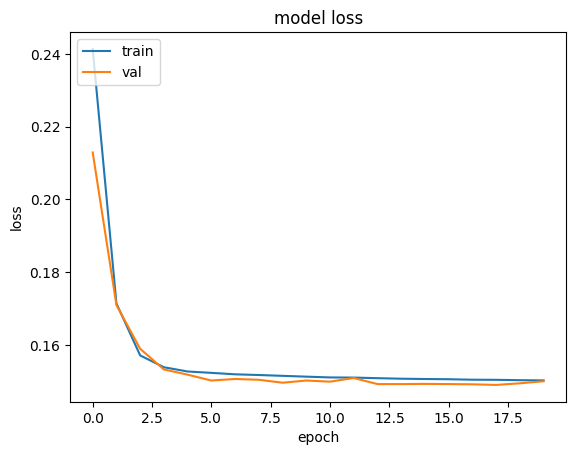

In [18]:
plot_loss(stacked_auto_encoder_1.history.history)

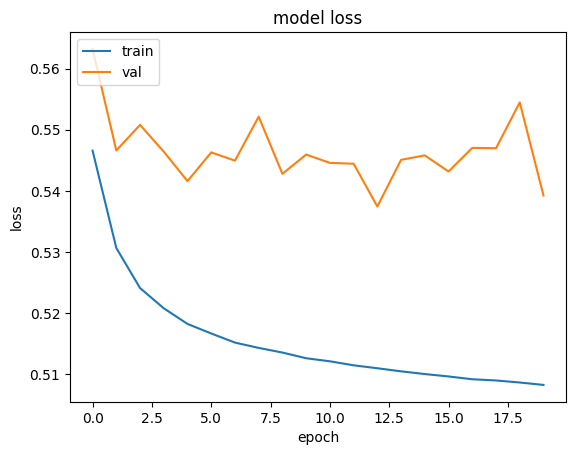

In [19]:
plot_loss(stacked_auto_encoder_2.history.history)

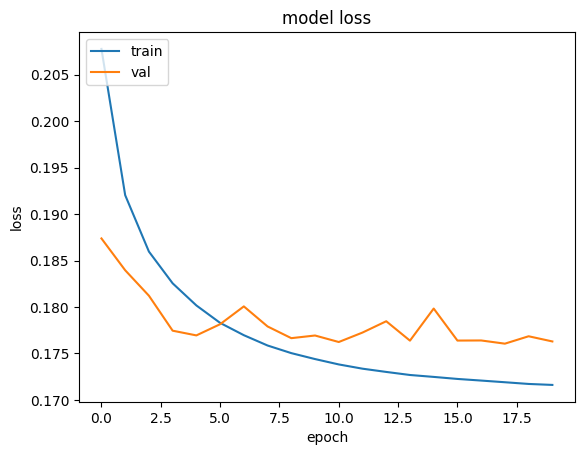

In [20]:
plot_loss(stacked_auto_encoder_3.history.history)

**Finetune the model by adding logistic regression layer**

In [21]:
# Create a 1 hot encoded Y_train
def create_one_hot(arr):
    out_arr = []
    for item in arr:
        max_arr = max(arr)
        one_hot_encoded = [0] * (max_arr+1)
        one_hot_encoded[item] = 1
        out_arr.append(one_hot_encoded)
    return np.array(out_arr)

Y_train_hot_encoded = create_one_hot(Y_train)
Y_val_hot_encoded = create_one_hot(Y_val)

In [22]:
fine_tuned_model_1, fine_tuned_encoder_1 = stacked_auto_encoder_1.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 1) 

Epoch 1/30
892/895 [============================>.] - ETA: 0s - loss: 2.7008
Epoch 1: val_loss improved from inf to 1.63276, saving model to weights.hdf5
895/895 [==============================] - 5s 4ms/step - loss: 2.7085 - val_loss: 1.6328
Epoch 2/30
890/895 [============================>.] - ETA: 0s - loss: 1.1341
Epoch 2: val_loss improved from 1.63276 to 0.98276, saving model to weights.hdf5
895/895 [==============================] - 4s 5ms/step - loss: 1.1407 - val_loss: 0.9828
Epoch 3/30
889/895 [============================>.] - ETA: 0s - loss: 0.6983
Epoch 3: val_loss improved from 0.98276 to 0.60187, saving model to weights.hdf5
895/895 [==============================] - 4s 5ms/step - loss: 0.6944 - val_loss: 0.6019
Epoch 4/30
894/895 [============================>.] - ETA: 0s - loss: 0.4393
Epoch 4: val_loss improved from 0.60187 to 0.55864, saving model to weights.hdf5
895/895 [==============================] - 4s 4ms/step - loss: 0.4389 - val_loss: 0.5586
Epoch 5/30
885/8

In [23]:
fine_tuned_model_2, fine_tuned_encoder_2 = stacked_auto_encoder_2.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 1)

Epoch 1/30
885/895 [============================>.] - ETA: 0s - loss: 2.4406
Epoch 1: val_loss improved from inf to 1.40896, saving model to weights.hdf5
895/895 [==============================] - 6s 6ms/step - loss: 2.4219 - val_loss: 1.4090
Epoch 2/30
895/895 [==============================] - ETA: 0s - loss: 1.0916
Epoch 2: val_loss improved from 1.40896 to 0.85017, saving model to weights.hdf5
895/895 [==============================] - 4s 5ms/step - loss: 1.0916 - val_loss: 0.8502
Epoch 3/30
894/895 [============================>.] - ETA: 0s - loss: 0.7010
Epoch 3: val_loss improved from 0.85017 to 0.59773, saving model to weights.hdf5
895/895 [==============================] - 4s 5ms/step - loss: 0.7003 - val_loss: 0.5977
Epoch 4/30
890/895 [============================>.] - ETA: 0s - loss: 0.5220
Epoch 4: val_loss improved from 0.59773 to 0.38553, saving model to weights.hdf5
895/895 [==============================] - 5s 6ms/step - loss: 0.5197 - val_loss: 0.3855
Epoch 5/30
885/8

In [24]:
fine_tuned_model_3, fine_tuned_encoder_3 = stacked_auto_encoder_3.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 1) 

Epoch 1/30
891/895 [============================>.] - ETA: 0s - loss: 2.5726
Epoch 1: val_loss improved from inf to 1.75854, saving model to weights.hdf5
895/895 [==============================] - 7s 6ms/step - loss: 2.5731 - val_loss: 1.7585
Epoch 2/30
892/895 [============================>.] - ETA: 0s - loss: 1.1874
Epoch 2: val_loss improved from 1.75854 to 1.31560, saving model to weights.hdf5
895/895 [==============================] - 5s 5ms/step - loss: 1.1917 - val_loss: 1.3156
Epoch 3/30
891/895 [============================>.] - ETA: 0s - loss: 0.7476
Epoch 3: val_loss improved from 1.31560 to 0.85828, saving model to weights.hdf5
895/895 [==============================] - 5s 5ms/step - loss: 0.7483 - val_loss: 0.8583
Epoch 4/30
890/895 [============================>.] - ETA: 0s - loss: 0.5705
Epoch 4: val_loss improved from 0.85828 to 0.58517, saving model to weights.hdf5
895/895 [==============================] - 6s 7ms/step - loss: 0.5703 - val_loss: 0.5852
Epoch 5/30
887/8

### Plot of Finetuning Training

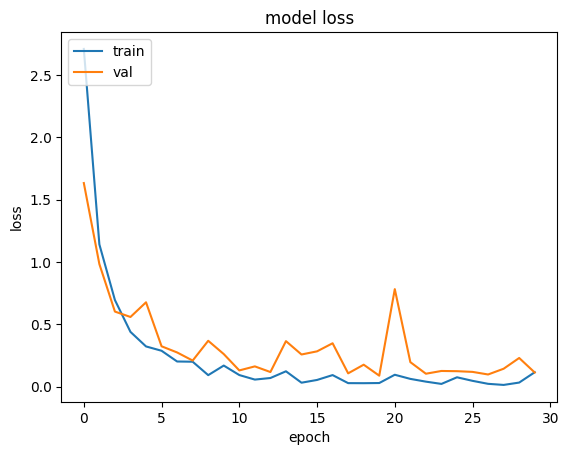

In [25]:
plot_loss(stacked_auto_encoder_1.history.history)

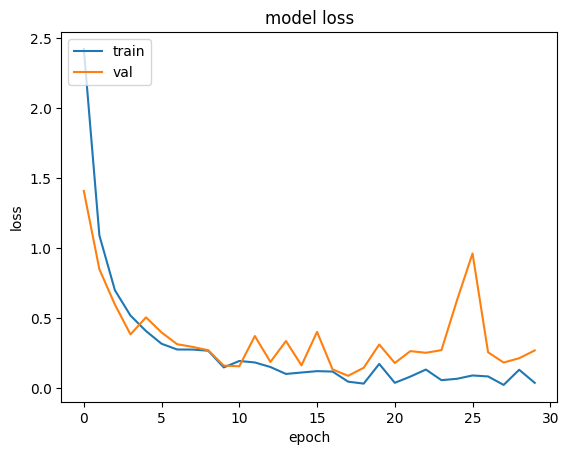

In [26]:
plot_loss(stacked_auto_encoder_2.history.history)

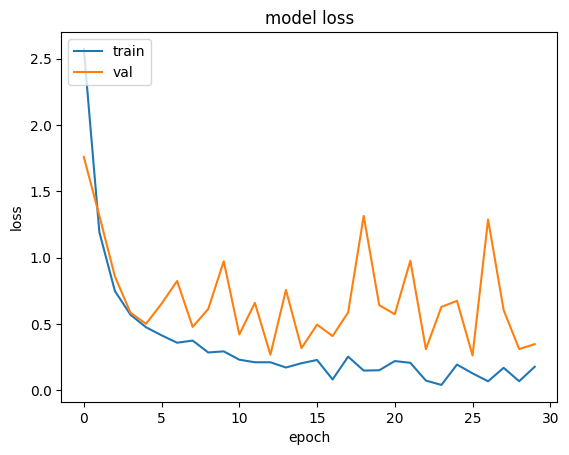

In [27]:
plot_loss(stacked_auto_encoder_3.history.history)

**Now feed the encoded representation into linear SVM**

In [28]:
fine_tuned_encoders = [fine_tuned_encoder_1, fine_tuned_encoder_2, fine_tuned_encoder_3]
for fine_tuned_encoder, model_name in zip(fine_tuned_encoders, model_names[1:]):
    print(model_name)
    X_train_encoded = fine_tuned_encoder.predict(X_train_scaled)

    # Fit to encoded data
    svm_autoencoder = SVC(kernel='linear', C=1, probability=True)
    svm_autoencoder.fit(X_train_encoded, Y_train)

    # Encode the test data and use SVM to predict its labels
    X_test_encoded = fine_tuned_encoder.predict(X_test_scaled)
    predicted = svm_autoencoder.predict(X_test_encoded)

    print("SVM Accuracy Score -> ", metrics.accuracy_score(predicted, Y_test)*100)
    predicted_arr.append(predicted)
    
    predicted_train = svm_autoencoder.predict(X_train_encoded)
    print("SVM Accuracy Score on training -> ", metrics.accuracy_score(predicted_train, Y_train)*100)

    X_val_encoded = fine_tuned_encoder.predict(X_val_scaled)
    predicted_val = svm_autoencoder.predict(X_val_encoded)
    print("SVM Accuracy Score on validation -> ", metrics.accuracy_score(predicted_val, Y_val)*100)

1-layer SDAE SVM
14/14 [==============================] - 0s 2ms/step
SVM Accuracy Score ->  96.41255605381166
SVM Accuracy Score on training ->  99.88826815642457
5/5 [==============================] - 0s 2ms/step
SVM Accuracy Score on validation ->  97.2972972972973
2-layers SDAE SVM
14/14 [==============================] - 0s 2ms/step
SVM Accuracy Score ->  94.17040358744396
SVM Accuracy Score on training ->  99.88826815642457
5/5 [==============================] - 0s 3ms/step
SVM Accuracy Score on validation ->  97.2972972972973
3-layers SDAE SVM
14/14 [==============================] - 0s 2ms/step
SVM Accuracy Score ->  93.72197309417041
SVM Accuracy Score on training ->  99.88826815642457
5/5 [==============================] - 0s 3ms/step
SVM Accuracy Score on validation ->  95.94594594594594


## 6. Testing metrics

In [29]:
def testing_metrics(y_true, y_pred_arr, model_names, export=True):
    stats = {}
    for y_pred, model_name in zip(y_pred_arr, model_names):
        scores = metrics.classification_report(y_true, y_pred, zero_division=1, output_dict=True)

        stats[model_name] = {
            'cohen_kappa': metrics.cohen_kappa_score(y_true, y_pred),
            'matthews_corrcoef': metrics.matthews_corrcoef(y_true, y_pred),
            'micro-accuracy': scores['accuracy']
        }

        for metr1 in ('macro avg', 'weighted avg'):
            for metr2 in ('precision', 'recall', 'f1-score'):
                stats[model_name][metr1 + ' ' + metr2] = scores[metr1][metr2]
    
    stats_df = pd.DataFrame.from_dict(stats).T
    if export:
        stats_df.to_csv('svm_stats.csv')
    
    return stats_df

In [30]:
testing_metrics(Y_test, predicted_arr, model_names)

,cohen_kappa,matthews_corrcoef,micro-accuracy,macro avg precision,macro avg recall,macro avg f1-score,weighted avg precision,weighted avg recall,weighted avg f1-score
Raw SVM,0.819071,0.821772,0.825112,0.881030,0.824921,0.837734,0.880422,0.825112,0.837551
1-layer SDAE SVM,0.962888,0.962963,0.964126,0.966423,0.964127,0.964198,0.966271,0.964126,0.964120
2-layers SDAE SVM,0.939691,0.939941,0.941704,0.948037,0.941429,0.941132,0.947720,0.941704,0.941138
3-layers SDAE SVM,0.935053,0.935272,0.937220,0.943550,0.936825,0.936844,0.943503,0.937220,0.937043
